In [37]:
import os
import sys
os.chdir('/home/zongchen/mmd_flow_cubature/')
sys.path.append('/home/zongchen/mmd_flow_cubature/')
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
jax.config.update("jax_platform_name", "cpu")

from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow

In [38]:
d = 2
cov = jnp.eye(d)
# cov = jnp.array([[2.0, 1.0], [1.0, 2.0]])
# means = jnp.array([-2.0, 2.0])
means = jnp.array([-0.0, 0.0])

cov_inv = jnp.linalg.inv(cov)
temp = jnp.exp(0.5 * (means.T @ cov_inv @ jnp.linalg.inv(cov_inv + 2 * jnp.eye(d)) @ cov_inv @ means))
temp *= jnp.exp(-0.5 * means.T @ cov_inv @ means)
temp * jnp.sqrt(jnp.linalg.det(2 * cov + jnp.eye(d)))
cov_new = jnp.linalg.inv(cov_inv + 2 * jnp.eye(d))
integral = temp * jnp.sqrt(jnp.linalg.det(cov_inv)) * jnp.sqrt(jnp.linalg.det(cov_new))
print(integral)

samples = jax.random.multivariate_normal(jax.random.PRNGKey(0), means, cov, (1000000,))
f_ = jnp.exp(-jnp.sum(samples**2, axis=1))
integral = jnp.mean(f_)
print(integral)

0.33333334
0.33334756


In [39]:
rng_key = jax.random.PRNGKey(0)
k = 20
sample_size = 100
weights = jnp.ones(k) / k
# covariances = jnp.load('data/mog_covs.npy')
# means = jnp.load('data/mog_means.npy')
means = jnp.ones([k, d])
covariances = jnp.array([jnp.eye(d) for _ in range(k)])

component_indices = jax.random.choice(rng_key, k, shape=(sample_size,), p=weights)
mean = means[component_indices, :]
cov = covariances[component_indices, :, :]

def sample_gaussian(mean, cov, key):
    return jax.random.multivariate_normal(key, mean, cov)

subkeys = jax.random.split(rng_key, sample_size)
iid_samples = jax.vmap(sample_gaussian)(mean, cov, subkeys)


In [60]:
import scipy.stats
component_indices = jax.random.choice(rng_key, k, shape=(sample_size,), p=weights)
unique_components, sample_sizes = jnp.unique(component_indices, return_counts=True)

mean = means[unique_components]
cov = covariances[unique_components]

def generate_qmc_samples(mean, cov, size):
    sobol = scipy.stats.qmc.Sobol(d)
    u = jnp.array(sobol.random(size))  # Generate Sobol sequence
    L = jnp.linalg.cholesky(cov)      # Compute Cholesky decomposition
    return mean + jax.scipy.stats.norm.ppf(u) @ L.T

# Generate samples for each unique Gaussian component
samples_dict = {
    int(unique_components[i]): generate_qmc_samples(mean[i], cov[i], sample_sizes[i])
    for i in range(len(unique_components))
}

# Map back to the original order given by component_indices
qmc_samples = jnp.concatenate([samples_dict[int(idx)] for idx in component_indices], axis=0)


/home/zongchen/miniconda3/envs/mmd_cubature/lib/python3.10/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [65]:
iid_samples.mean(0)

Array([0.8714856 , 0.98650783], dtype=float32)

Text(0.5, 1.0, 'QMC samples')

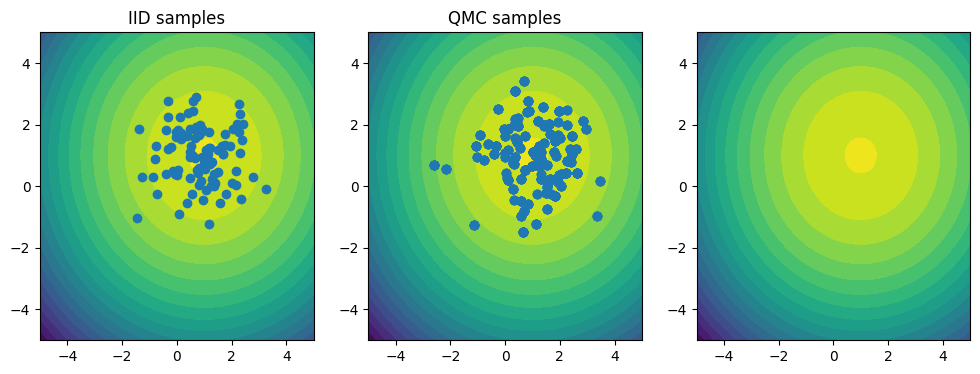

In [61]:
kernel = gaussian_kernel(1.0)
distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)

x_range = (-5, 5)
y_range = (-5, 5)
resolution = 100
x_vals = jnp.linspace(x_range[0], x_range[1], resolution)
y_vals = jnp.linspace(y_range[0], y_range[1], resolution)
X, Y = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([X.ravel(), Y.ravel()], axis=1)
logpdf = jnp.log(distribution.pdf(grid).reshape(resolution, resolution))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
contour = axs[0].contourf(X, Y, logpdf, levels=20, cmap='viridis')
contour = axs[1].contourf(X, Y, logpdf, levels=20, cmap='viridis')
contour = axs[2].contourf(X, Y, logpdf, levels=20, cmap='viridis')

axs[0].scatter(iid_samples[:, 0], iid_samples[:, 1], label='iid samples')
axs[0].set_title('IID samples')
axs[1].scatter(qmc_samples[:, 0], qmc_samples[:, 1], label='qmc samples')
axs[1].set_title('QMC samples')


In [42]:
means.shape

(20, 2)

In [43]:
weights.shape

(20,)